# Lab 4 - Kernel Regularized Least Squares
## Hesam Mohebi
In this lab activity we consider the extension of regularized least squares to non-linear problems using kernel functions.

A brief summary of the tasks:
 1. Generate a simple non-linear data-set
 2. Use **linear** RLS to try and learn with such dataset
 3. Use a **feature transformation** for learning with non-linear data
 4. Implement various kernel functions
 5. Implement kernel RLS
 6. Generate a more complex non-linear data-set
 7. Use kernel RLS for learning on non-linear data, use cross-validation to find the best hyperparameters.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import os

In [6]:
def calc_err(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

# Part 1: Learning with a simple non-linear dataset

## Generate quadratic data

In this lab we are going to use regression datasets where the target `Y` is **not a linear function** of the inputs `X`.

As a first example, see the following function to generate quadratic data.

In [7]:
def quadratic_data_gen(n, w, sigma_noise):
    X = np.random.uniform(-3, 3, size=(n, 1))
    Xsq = X ** 2
    noise = np.random.normal(0, sigma_noise, size=(n, 1))

    # Here we can use scalar multiplication since in dimension 1
    Y = Xsq * w + noise
    
    return X, Y

Shape of x: (100, 1), shape of y: (100, 1)


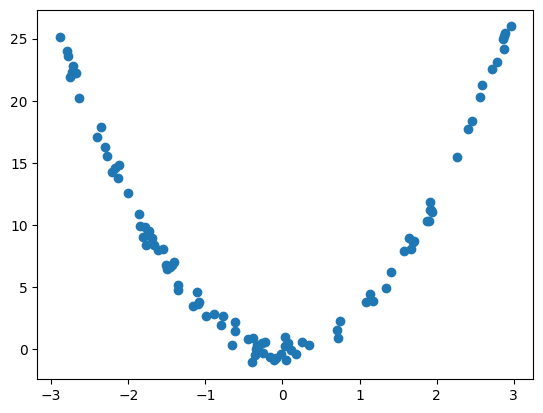

In [8]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

print(f"Shape of x: {x_tr.shape}, shape of y: {y_tr.shape}")
fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr);

## Task 1: Linear RLS

The implementation of linear regularized least-squares is given below in the functions `rls_train` and `rls_predict`. 

Remember: regularized least-squares has the following form

$$(X_{tr}^\top X_{tr} + \lambda n I)w = X_{tr}^\top Y_{tr}$$


Tasks:
 - Use RLS to train a linear regressor for the quadratic data. Comment on the results.

In [9]:
def rls_train(x, y, reg_par):
    cov = x.T @ x + reg_par * x.shape[0] * np.eye(x.shape[1])
    rhs = x.T @ y
    w = np.linalg.solve(cov, rhs)
    return w

def rls_predict(x, w):
    return x @ w

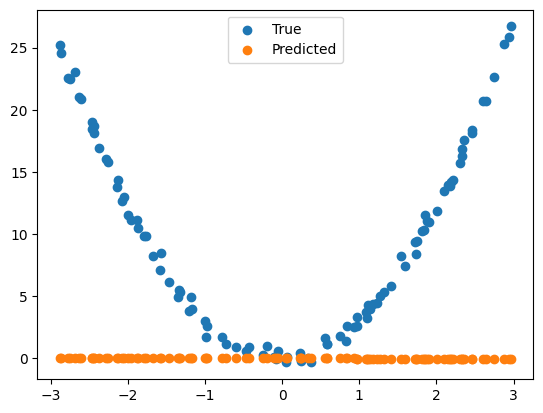

In [10]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)


w = rls_train(x_tr, y_tr, 0.001)
pred_tr = rls_predict(x_tr, w)

fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="best")

The linear regressor was unable to predict the pattern in quadratic data since the linear model assumes a straight line relationship between features and target.

## Task 2: Feature transform

There is a simple way to use a linear algorithm for learning non-linear data: transforming the input data in such a way to convert the problem into a linear one.

This is a simple fix in some cases, but becomes cumbersome if the datasets are non-linear in a complex way.

Here we adopt this approach to train a RLS classifier with the quadratic dataset:
 1. Generate the quadratic dataset
 2. Transform the data so that it becomes a (n, 2) matrix containing the original input, and a transformed version of itself. Clearly the correct transformation depends on the underlying function (a quadratic function!).
 3. Use the RLS algorithm on the new dataset
 4. Plot **and comment** on the results

In [11]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

# Instead of just the given xs build a feature matrix with the xs and their squares:
trsf_x_tr = np.concatenate([x_tr, x_tr**2], axis=1)
assert trsf_x_tr.shape == (x_tr.shape[0], 2), f"Shape of x_tr is {x_tr.shape}. Expected ({x_tr.shape[0]}, 2)"

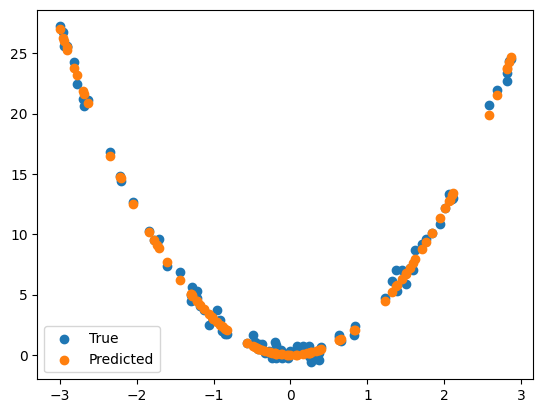

In [12]:
# Now train a linear regression function on the new data!
trsf_w_rls = rls_train(trsf_x_tr,y_tr, 0.001)
pred_tr = rls_predict(trsf_x_tr, trsf_w_rls)

fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="best")

By applying feature transformation the linear regressor is now capable of finding the relationship between featurs and targets and thus, enabled the linear model to fit the quadratic data.

# Part 2: Kernel Least Squares

## Implement 3 types of kernel

The `kernel_matrix` function takes as input two arrays of data, and outputs the kernel matrix evaluated at every pair of points.

You should implement it using the formulas seen in class for the following kernels:
 - linear kernel -- here the `param` argument can be ignored
 - polynomial kernel -- here the `param` argument is the exponent of the kernel
 - gaussian kernel -- here the `param` argument is the kernel length-scale ($\sigma$)

In [13]:
def squared_distances(X1, X2):
    """Compute the matrix of pairwise squared-distances between all points in X1 and in X2.
    """
    return scipy.spatial.distance.cdist(X1, X2, metric='seuclidean')

In [14]:
def kernel_matrix(X1, X2, kernel_type, param):
    # X1 : array of shape n x d
    # X2 : array of shape m x d
    if kernel_type == 'linear':
        return np.dot(X1, X2.T)
    elif kernel_type == 'polynomial':
        exponent = param
        return (np.dot(X1, X2.T) + 1) ** exponent
    elif kernel_type == 'gaussian':
        lengthscale = param
        return np.exp(-squared_distances(X1,X2)/ (2 * (lengthscale ** 2) ))
    else:
        raise ValueError(kernel_type)

**Task:** Visualize the kernel (e.g. of the Gaussian type) for random data with different length-scales. What can you observe?

Text(0.5, 1.0, 'Gaussian kernel with sigma=5.000000')

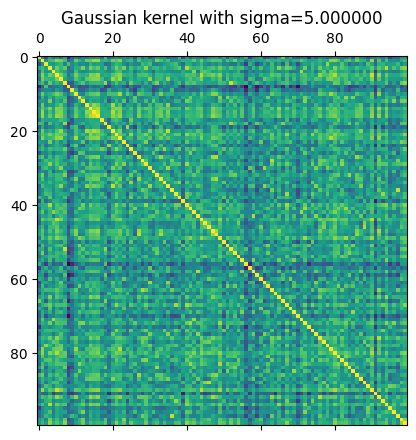

In [15]:
D = np.random.randn(100, 5)
lengthscale = 5
K = kernel_matrix(D, D, "gaussian", lengthscale)
fig, ax = plt.subplots()
ax.matshow(K)
ax.set_title("Gaussian kernel with sigma=%f" % (lengthscale))

-   Small Length-Scales (σ=0.01,0.1): These are too localized, leading to a model that is overly sensitive to small variations in the data (prone to overfitting).
-   Large Length-Scales (σ=10,100):
These are too smooth, ignoring meaningful variations in the data and treating distant points as overly similar (prone to underfitting).
### best choise (1<σ<10)
-   It captures enough local similarity without overfitting or underfitting.
-   Off-diagonal elements show meaningful interactions between points that are not too far apart. 

## Implement Kernel RLS

Remember that, given kernel $K = k(x_i, x_j)$ for $i=(1, \dots, n)$ and $j=(1, \dots, n)$, KRLS learns a weight-vector with the following formula

$$(K + n \lambda I)w = Y$$

and then predictions on some new point $\tilde{x}$ are given by

$$f^{\mathrm{KRLS}}(\tilde{x}) = k(\tilde{x}, X^{\mathrm{train}}) w$$

In [16]:
def krls_train(x, y, reg_par, kernel_type, kernel_par):
    n = x.shape[0]
    K = kernel_matrix(x, x, kernel_type, kernel_par)
    K_reg = K + n * reg_par * np.eye(n)
    w = np.linalg.solve(K_reg, y)
    return w
def krls_predict(x_ts, x_tr, w, kernel_type, kernel_par):
    K_ts = kernel_matrix(x_ts, x_tr, kernel_type, kernel_par)
    return np.dot(K_ts, w)

Now test the functions you have implemented on the quadratic dataset.

**Tasks:**
 1. use the linear kernel, can you fit the data?
 2. use the polynomial kernel, test the effect of the kernel parameter on the results:
    - describe what happens with a low/high exponent in terms of the bias-variance tradeoff.
 3. use the polynomial kernel, but fix the kernel parameter. Test the effect of the regularization parameter
    - describe what happens with a low/high regularizer in terms of the bias-variance tradeoff

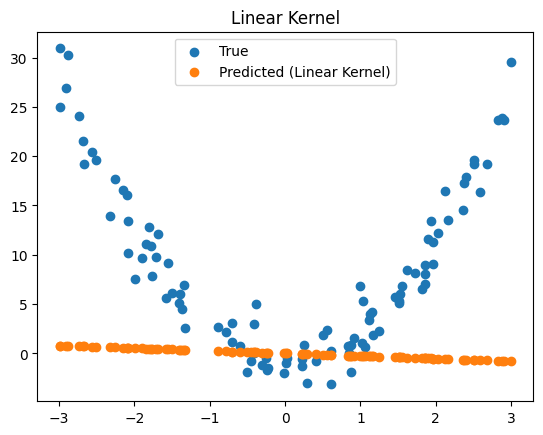

In [17]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 2.0)

# Insert your code here
w_linear = krls_train(x_tr, y_tr, reg_par=0.1, kernel_type='linear', kernel_par=5)
pred_linear = krls_predict(x_tr, x_tr, w_linear, 'linear', 5)
plt.scatter(x_tr, y_tr, label="True")
plt.scatter(x_tr, pred_linear, label="Predicted (Linear Kernel)")
plt.legend()
plt.title("Linear Kernel")
plt.show()

### No The linear model is unable to predict the quadratic data

C:\Users\moheb\AppData\Local\Temp\ipykernel_21296\3547386306.py:8: RuntimeWarning: invalid value encountered in power
  return (np.dot(X1, X2.T) + 1) ** exponent


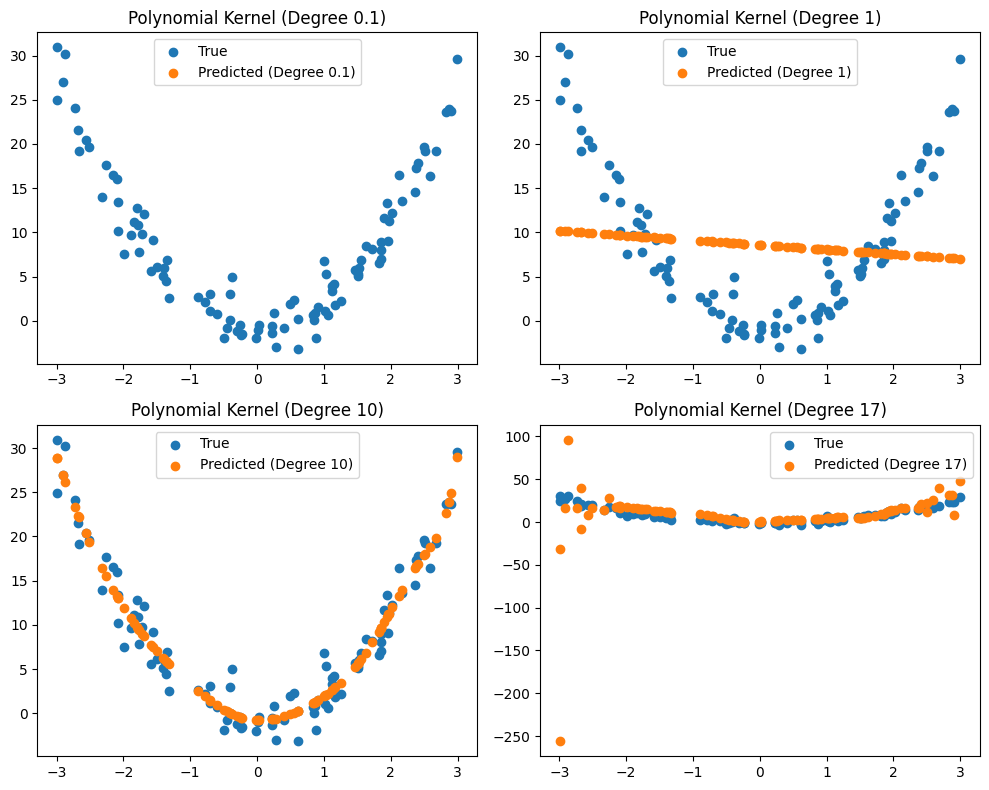

In [18]:
import matplotlib.pyplot as plt

degrees = [0.1, 1, 10, 17]

fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 

axes = axes.flatten()

for i, degree in enumerate(degrees):
    w_poly = krls_train(x_tr, y_tr, reg_par=0.001, kernel_type="polynomial", kernel_par=degree)
    pred_poly = krls_predict(x_tr, x_tr, w_poly, kernel_type="polynomial", kernel_par=degree)
    
    ax = axes[i]
    ax.scatter(x_tr, y_tr, label="True")
    ax.scatter(x_tr, pred_poly, label=f"Predicted (Degree {degree})")
    ax.set_title(f"Polynomial Kernel (Degree {degree})")
    ax.legend(loc="best")

plt.tight_layout()
plt.show()


-   For low degree, the predictions will be overly smooth (underfitting).
-   For high degree, the predictions may oscillate wildly, especially near the data points (overfitting).

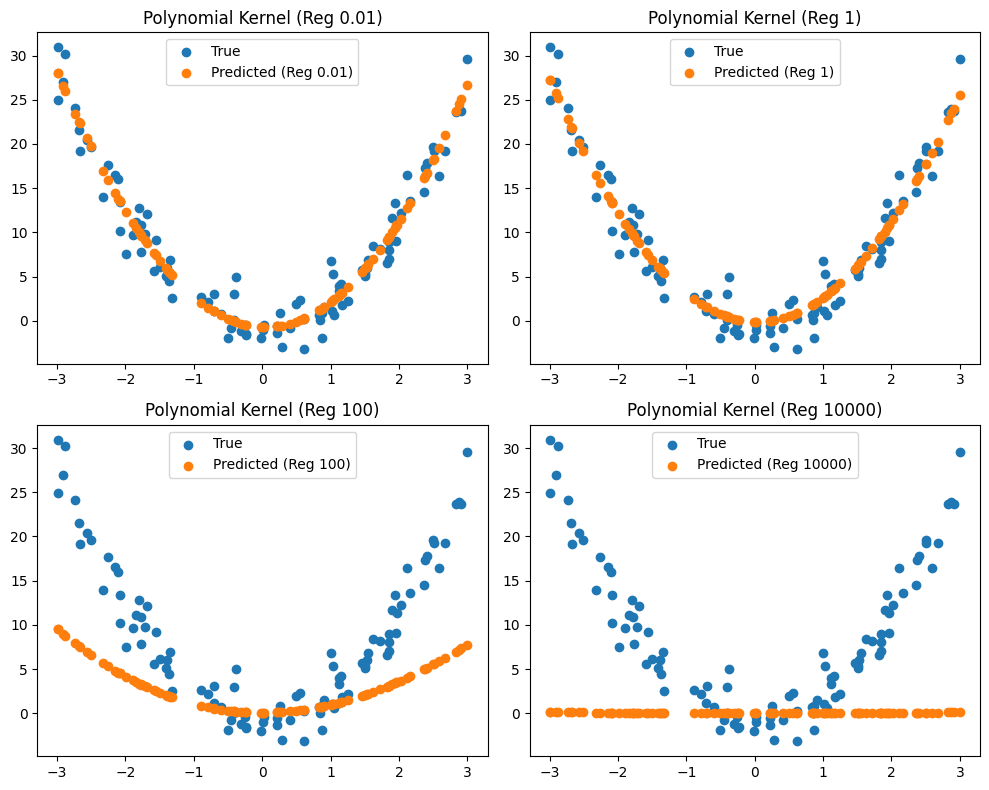

In [19]:
import matplotlib.pyplot as plt

# Define regularization parameters to test
reg_params = [ 0.01, 1, 100, 10000]

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust size as needed

# Flatten axes for easier iteration
axes = axes.flatten()

# Generate plots for each regularization parameter
for i, reg_par in enumerate(reg_params):
    w_poly_reg = krls_train(x_tr, y_tr, reg_par=reg_par, kernel_type="polynomial", kernel_par=3)
    pred_poly_reg = krls_predict(x_tr, x_tr, w_poly_reg, kernel_type="polynomial", kernel_par=3)
    
    # Plot on the respective subplot
    ax = axes[i]
    ax.scatter(x_tr, y_tr, label="True")
    ax.scatter(x_tr, pred_poly_reg, label=f"Predicted (Reg {reg_par})")
    ax.set_title(f"Polynomial Kernel (Reg {reg_par})")
    ax.legend(loc="best")

# Adjust layout
plt.tight_layout()
plt.show()


-   Low Regularizer: Low bias, high variance. Risk of overfitting.
-   Moderate Regularizer: Balanced bias and variance. Ideal tradeoff.
-   High Regularizer: High bias, low variance. Risk of underfitting.
-   Very High Regularizer: Extreme bias, minimal variance. Severe underfitting.

## Generating a more complex non-linear dataset

Define a function to generate a d-dimensional synthetic dataset where the targets `Y` depend non-linearly on the variables `X`.

The parameters of the function are:
 - n : the number of samples
 - d : the dimension of the samples
 - low_d : the lower-bound for the uniformly distributed samples
 - high_d : the higher-bound for the uniformly distributed samples
 - sigma_noise : standard deviation of Gaussian noise added to the targets
 
It should return:
 - X : 2D array of size n, d which fits in the desired bounds
 - Y : 2D array of size n, 1 which is a non-linear function of `X` (and a linear function of `w`)
 
Examples of non-linear regression functions:
 - polynomial dependence of the Y on the X data
 - logarithmic dependence
 - more complex transforms (e.g. trig functions)


In [27]:
def nonlinear_data_gen(n, d, low_d, high_d, sigma_noise):
    X = np.random.uniform(low=low_d, high=high_d, size=(n, d))
    assert X.shape == (n, d), "Shape of X incorrect"
    
    Y = (0.5 * np.sum(X**2, axis=1, keepdims=True) + np.sin(np.sum(X, axis=1, keepdims=True)) + 2 * np.sum(X[:, :1], axis=1, keepdims=True))
    assert Y.shape == (n, 1), "Shape of Y incorrect"
    
    # Add noise
    noise = np.random.normal(0, sigma_noise, size=(n, 1))
    Y_noisy = Y + noise
    
    return X, Y_noisy

## KRLS and cross-validation
Now we will use KRLS and k-fold CV to learn on the complex non-linear datasets we have generated.

In this last part you will have to do the following:
 1. Generate a non-linear dataset, find the best hyperparameters (using e.g. the Gaussian kernel) with the training set, and then use them to make predictions on the test-set. Are you able to fit your data well?
 2. Analyse how the amount of noise (see the `sigma_noise` parameter of `nonlinear_data_gen`) influences the best lambda as selected by cross-validation. In particular answer to the following question:
     - How does the best lambda change as you increase/decrease the amount of noise in your dataset? Why? 
     
    **Hint: keep the kernel parameter fixed for this third task, otherwise it might be very hard to see**

In [21]:
def krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par):
    """
    Compute the k-fold cross-validation error for one KRLS model (with speficied regularization, 
    kernel and kernel parameter).
    
    This function returns both the training errors and the validation errors 
    obtained from CV (as numpy arrays).
    """
    if num_folds <= 1:
        raise Exception("Please supply a number of folds > 1")

    n_tot = x_tr.shape[0]
    n_val = int(n_tot // num_folds)
    
    tr_errs, val_errs = [], []
    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    for fold in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold]] = True
        
        kf_x_tr = x_tr[~val_mask]
        kf_y_tr = y_tr[~val_mask]
        kf_x_val = x_tr[val_mask]
        kf_y_val = y_tr[val_mask]
        
        w_krls = krls_train(kf_x_tr, kf_y_tr, reg_par=reg_par, kernel_type=kernel_type, kernel_par=kernel_par)
        
        pred_tr = krls_predict(kf_x_tr, kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)
        pred_val = krls_predict(kf_x_val, kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)
        tr_errs.append(calc_err(pred_tr, kf_y_tr))
        val_errs.append(calc_err(pred_val, kf_y_val))
    return np.asarray(tr_errs), np.asarray(val_errs)

In [22]:
def krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, kernel_type, kernel_par_list):
    """Choose the best parameters for both the regularizer and the kernel parameter according to K-Fold CV.
    """
    errors = np.zeros((len(reg_par_list), len(kernel_par_list)))
    for i, reg_par in enumerate(reg_par_list):
        for j, kernel_par in enumerate(kernel_par_list):
            tr_error, val_error = krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par)
            errors[i][j] = np.mean(val_error)
            
    best_reg_par = reg_par_list[np.unravel_index(np.argmin(errors), errors.shape)[0]]
    best_kernel_par = kernel_par_list[np.unravel_index(np.argmin(errors), errors.shape)[1]]
    best_err = np.min(errors)
    print(f"The best error (MSE={best_err*100:.2f}%) was obtained with "
          f"lambda={best_reg_par}, kernel-parameter={best_kernel_par}")
    return best_reg_par, best_kernel_par, best_err

In [29]:
# Data gen parameters
n_train = 500 
n_test = 100         
d = 3            
low_d = -5        
high_d = 5       
sigma_noise = 0.5

x_tr, y_tr = nonlinear_data_gen(n_train, d, low_d, high_d, sigma_noise)
x_ts, y_ts = nonlinear_data_gen(n_test, d, low_d, high_d, sigma_noise)

reg_par_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 2000]
kernel_par_list = [0.1, 0.5, 1, 2, 10, 20]

best_reg_par, best_kernel_par, best_err = krls_kfoldcv(
    x_tr, y_tr, 5, reg_par_list, kernel_type='gaussian', kernel_par_list=kernel_par_list
)

w_krls = krls_train(x_tr, y_tr, reg_par=best_reg_par, kernel_type='gaussian', kernel_par=best_kernel_par)
pred_test = krls_predict(x_ts, x_tr, w_krls, kernel_type='gaussian', kernel_par=best_kernel_par)
test_error = calc_err(pred_test, y_ts)
print(f"Test Error: MSE = {test_error * 100:.2f}%")

The best error (MSE=281.52%) was obtained with lambda=0.001, kernel-parameter=1
Test Error: MSE = 219.72%


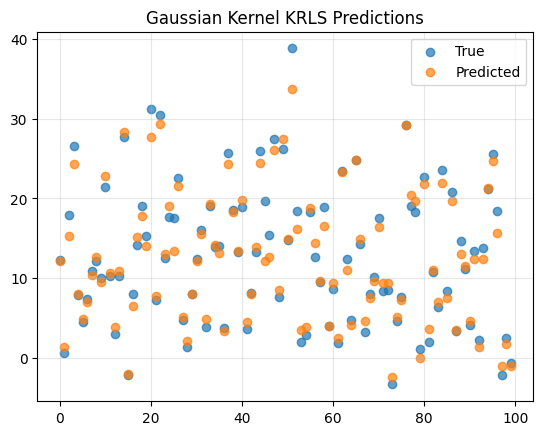

In [32]:
plt.scatter(np.arange(len(y_ts)), y_ts, label="True", alpha=0.7)
plt.scatter(np.arange(len(pred_test)), pred_test, label="Predicted", alpha=0.7)
plt.title("Gaussian Kernel KRLS Predictions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [33]:
# TODO: Analyse the effect of noise!
sigma = 2 
noise_levels = [0.01,0.1, 0.5, 1, 2, 5]
best_lambdas = []

for noise in noise_levels:
    x_tr, y_tr = nonlinear_data_gen(n_train, d, low_d, high_d, sigma_noise=noise)
    
    best_reg_par, _, _ = krls_kfoldcv(
        x_tr, y_tr, 10, reg_par_list, kernel_type='gaussian', kernel_par_list=[sigma]
    )
    best_lambdas.append(best_reg_par)

The best error (MSE=289.06%) was obtained with lambda=0.001, kernel-parameter=2
The best error (MSE=342.10%) was obtained with lambda=0.001, kernel-parameter=2
The best error (MSE=326.54%) was obtained with lambda=0.001, kernel-parameter=2
The best error (MSE=414.88%) was obtained with lambda=0.001, kernel-parameter=2
The best error (MSE=785.17%) was obtained with lambda=0.001, kernel-parameter=2
The best error (MSE=3135.65%) was obtained with lambda=0.001, kernel-parameter=2


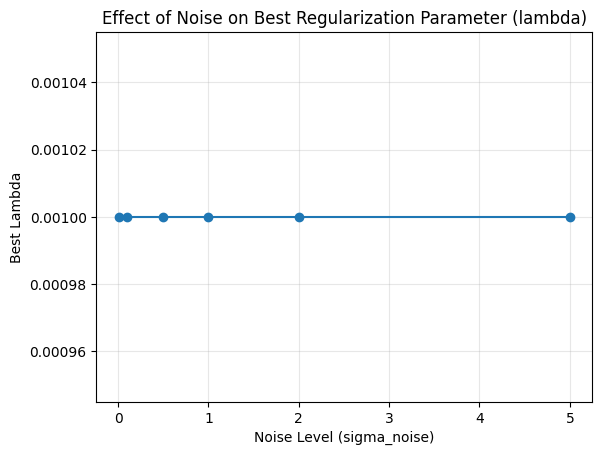

In [34]:
plt.plot(noise_levels, best_lambdas, marker="o")
plt.title("Effect of Noise on Best Regularization Parameter (lambda)")
plt.xlabel("Noise Level (sigma_noise)")
plt.ylabel("Best Lambda")
plt.grid(alpha=0.3)
plt.show()

As noise increases, the model struggles to capture patterns accurately, leading to higher MSE. This behavior aligns with expectations, as noise adds uncertainty to the data. The Gaussian kernel with a parameter of 2 and regularization of 0.01 is well-suited for capturing the underlying structure in low-noise scenarios.